# Training on online dataset
author: Pinglei He, Igor Augusto Oliveira

## Mounting google drive

In [1]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

# list content of the directory to ensure the mounting is successful
!ls ./drive/MyDrive/Medical-Noise-Cancellation

# add project root to python module paths
import sys
sys.path.insert(0, "/content/drive/MyDrive/Medical-Noise-Cancellation")

Mounted at /content/drive
archives		 model		unet-training.ipynb
bm3d			 model_gpu	unet-training-online.ipynb
data			 README.md	weights
data-augmentation.ipynb  result_images	weights_first_run
evaluation		 runs


## Hardware information

In [2]:
# colab GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# determine whether the current is high-RAM for choosing the right batch size
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('Using a high-RAM runtime!')

Tue Apr 26 13:09:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module imports

In [3]:
import matplotlib.pyplot as plt # for plotting
from torch.utils.data import DataLoader
from torch.nn import MSELoss # mean square error loss
from torch import Tensor
from torch.optim.lr_scheduler import OneCycleLR # learning rate decay
from torch.optim import AdamW
from tqdm import tqdm # progress bar
from torch.utils.tensorboard import SummaryWriter # for saving metrics and losses
import torch
import pickle # for saving model state
import numpy as np
from PIL import Image

In [4]:
# custom modules fitted for batch training with cuda / GPU
from model_gpu import (StentOnlineDataset,
                        StentDataset,
                        UNet) # our PyTorch U-Net model

## Parameters

In [5]:
# root directory of the project
root_dir = "drive/MyDrive/Medical-Noise-Cancellation/" # google drive

# parameters used in training
n_images = 10005 # number of images
batch_size = 5 # training set batch size ie. number of images per iteration
val_batch_size = 1 # validation set batch size
lr = 0.0002 # initial learning rate

# learning rate decay parameters
# scheduler_patience = 80 # set number of validations with no improvement after which the scheduler would decrease the lr
# lr_schedule_factor = 0.1 # new_lr = lr * schedule_factor when learning rate is decayed

# parameters about previously trained / cached weights
use_cached_weights = False # use models weights that we cached at checkpoint
path_weights = root_dir + "weights/unet-model_7000.pkl" # path to cached weights
previous_iter_count = 7000 # number of iterations we trained the model for before launching this notebook if use_cached_weights


## Initialization

In [6]:
# clear GPU memory if cuda used
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [7]:
# instantiate the model
model = None
if use_cached_weights:
    # load pretrained model with pickle
    with open(path_weights, "rb") as f:
        model = pickle.load(f)
else:
    # create new model
    model = UNet(in_channels=1, out_channels=1)
    # use double precision
    # model.double()

# print information on GPU availability of current runtime
if torch.cuda.is_available():
    model = model.cuda()
    if not next(model.parameters()).is_cuda:
      print("There is a CUDA device available, but the model was not successfuly sent to it.")
    else:
      print("Model successfully loaded to cuda.")

Model successfully loaded to cuda.


In [8]:
# custom image dataset class with real-time augmentation
dataset = StentOnlineDataset(n_images=n_images, base_image_path=root_dir + "data/dataset/base_png")
# pytorch dataset object
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# validation set
val_dataset = StentDataset(input_path=root_dir + "data/dataset/val_noisy_png",
                           target_path=root_dir + "data/dataset/val_base_png")
val_data_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [9]:
# mean square error for avoiding the model to over-whiten the output image when the stent sizes are small
criterion = MSELoss()
# optimizer = Adam(model.parameters(), lr=lr)
# scheduler = ReduceLROnPlateau(optimizer, 
#                               mode='min', 
#                               patience=scheduler_patience, 
#                               verbose=True, 
#                               factor=lr_schedule_factor)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=int(n_images/batch_size))

## Model Summary

In [10]:
print(model)

UNet(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_down_0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_down_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_down_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_down_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_down_4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(

## Training

In [11]:
# save the losses for analysis
# writer = SummaryWriter(log_dir=root_dir + "runs/2022_04_25_b")
train_losses = []
val_losses = []
lrs = []

In [12]:
# training
for i, data in enumerate(tqdm(data_loader)):
    # get the inputs
    inputs, targets = data
    # send to GPU
    if torch.cuda.is_available():
      inputs = inputs.cuda()
      targets = targets.cuda()
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # record the losss
    # writer.add_scalar('Loss/train', loss.item(), i)
    # writer.add_scalar("Log loss/train", np.log(loss.item()), i)
    train_losses.append(loss.item())
    lrs.append(optimizer.param_groups[0]["lr"])

    # print metric on validation set every 10 iterations
    if i % 10 == 0:
      running_loss = 0.0
      for vdata in val_data_loader:
        vinputs, vtargets = vdata
        if torch.cuda.is_available():
          vinputs = vinputs.cuda()
          vtargets = vtargets.cuda()
        voutputs = model(vinputs)
        vloss = criterion(voutputs, vtargets)
        running_loss += vloss.item()
      
      avg_vloss = running_loss / 3
      print(f"Validation loss: {avg_vloss}")
      # writer.add_scalar("Loss/validation", avg_vloss, i)
      # writer.add_scalar("Log loss/validation", np.log(avg_vloss), i)
      # writer.add_scalar("Log10 lr", np.log10(optimizer.param_groups[0]['lr']), i)
      val_losses.append(avg_vloss)


      # learning rate decays when the validation loss plateaus
      

    # checkpoint
    if i % 500 == 0:
      torch.save(model.state_dict(), root_dir + f"weights/iter_{i:05d}.pt")
      # with open(root_dir + "weights/scheduler.pickle", "wb") as f:
      #   pickle.dump(scheduler, f)
      with open(root_dir + "weights/losses.pickle", "wb") as f:
        pickle.dump({"train_losses": train_losses, "val_losses": val_losses, "lrs": lrs}, f)


    # show image
    if i < 20 or i < 200 and i % 5 == 0 or i < 1000 and i % 50 == 0 or i % 200 == 0:
        # if using cuda, copy input tensor and output tensor to CPU for printing
        if torch.cuda.is_available():
          inputs = Tensor.cpu(inputs)
          outputs = Tensor.cpu(outputs)
          targets = Tensor.cpu(targets)
        print(f"Step [{i + 1}/{len(data_loader)}], Loss:{loss.item()}, Lr: {optimizer.param_groups[0]['lr']}")
        # print("Original image:")
        plt.figure()
        plt.imshow(inputs.detach().numpy()[0, 0, 94:-94, 94:-94], cmap="gray")
        plt.savefig(root_dir + f"result_images/iter_{i:05d}_input.png", bbox_inches='tight')
        # plt.show()

        # print("Predicted image:")
        plt.figure()
        plt.imshow(outputs.detach().numpy()[0, 0], cmap="gray")
        plt.savefig(root_dir + f"result_images/iter_{i:05d}_prediction.png", bbox_inches='tight')
        # plt.show()

        # print("Ground truth:")
        plt.figure()
        plt.imshow(targets.detach().numpy()[0, 0], cmap="gray")
        plt.savefig(root_dir + f"result_images/iter_{i:05d}_target.png", bbox_inches='tight')
        # plt.show()

        plt.close("all")

  0%|          | 0/2001 [00:00<?, ?it/s]

Validation loss: 1.0520263691603413
Step [1/2001], Loss:1.0531486072013352, Lr: 8.001319020158374e-06


  0%|          | 1/2001 [00:20<11:31:42, 20.75s/it]

Step [2/2001], Loss:1.037221399809771, Lr: 8.005276044387356e-06


  0%|          | 2/2001 [00:29<7:36:46, 13.71s/it] 

Step [3/2001], Loss:1.0158840650887593, Lr: 8.011870963949577e-06


  0%|          | 3/2001 [00:37<6:12:55, 11.20s/it]

Step [4/2001], Loss:1.0420441495800785, Lr: 8.021103597619344e-06


  0%|          | 4/2001 [00:45<5:30:55,  9.94s/it]

Step [5/2001], Loss:1.0517396345750933, Lr: 8.03297369168771e-06


  0%|          | 5/2001 [00:53<5:09:17,  9.30s/it]

Step [6/2001], Loss:1.0148717399913683, Lr: 8.047480919969388e-06


  0%|          | 6/2001 [01:01<4:53:23,  8.82s/it]

Step [7/2001], Loss:1.0296322623606553, Lr: 8.064624883811778e-06


  0%|          | 7/2001 [01:09<4:42:11,  8.49s/it]

Step [8/2001], Loss:1.0392365670913464, Lr: 8.08440511210578e-06


  0%|          | 8/2001 [01:17<4:35:00,  8.28s/it]

Step [9/2001], Loss:1.038185706582293, Lr: 8.106821061298967e-06


  0%|          | 9/2001 [01:25<4:33:38,  8.24s/it]

Step [10/2001], Loss:1.040062086482835, Lr: 8.131872115410251e-06


  0%|          | 10/2001 [01:33<4:33:51,  8.25s/it]

Validation loss: 1.033415089818415
Step [11/2001], Loss:1.0343602441767046, Lr: 8.159557586047092e-06


  1%|          | 11/2001 [01:44<4:53:53,  8.86s/it]

Step [12/2001], Loss:1.0183906654559085, Lr: 8.189876712424147e-06


  1%|          | 12/2001 [01:52<4:46:56,  8.66s/it]

Step [13/2001], Loss:1.006217857706019, Lr: 8.22282866138436e-06


  1%|          | 13/2001 [02:00<4:40:08,  8.45s/it]

Step [14/2001], Loss:1.022588545907201, Lr: 8.258412527421837e-06


  1%|          | 14/2001 [02:08<4:34:59,  8.30s/it]

Step [15/2001], Loss:1.0163514308919201, Lr: 8.296627332706619e-06


  1%|          | 15/2001 [02:16<4:34:43,  8.30s/it]

Step [16/2001], Loss:1.0354209914803585, Lr: 8.33747202711165e-06


  1%|          | 16/2001 [02:24<4:31:24,  8.20s/it]

Step [17/2001], Loss:1.0256869190512627, Lr: 8.380945488241598e-06


  1%|          | 17/2001 [02:32<4:28:01,  8.11s/it]

Step [18/2001], Loss:1.020298702859313, Lr: 8.427046521463798e-06


  1%|          | 18/2001 [02:40<4:25:45,  8.04s/it]

Step [19/2001], Loss:1.011268117810935, Lr: 8.475773859940785e-06


  1%|          | 19/2001 [02:48<4:24:48,  8.02s/it]

Step [20/2001], Loss:1.0114879020960337, Lr: 8.527126164665556e-06


  1%|          | 20/2001 [02:56<4:23:09,  7.97s/it]

Validation loss: 1.0138895090705355
Step [21/2001], Loss:1.026749977522579, Lr: 8.581102024497918e-06


  1%|          | 25/2001 [03:31<3:46:15,  6.87s/it]

Step [26/2001], Loss:1.0082656746505851, Lr: 8.89028021611388e-06


  1%|▏         | 30/2001 [04:04<3:33:16,  6.49s/it]

Validation loss: 0.9942041304204224
Step [31/2001], Loss:0.9859780577231063, Lr: 9.264794211410137e-06


  2%|▏         | 35/2001 [04:40<3:37:05,  6.63s/it]

Step [36/2001], Loss:0.9887177915925566, Lr: 9.704386737282282e-06


  2%|▏         | 40/2001 [05:12<3:30:33,  6.44s/it]

Validation loss: 0.9713002246664209
Step [41/2001], Loss:0.9607716028011276, Lr: 1.020875581480497e-05


  2%|▏         | 45/2001 [05:48<3:35:50,  6.62s/it]

Step [46/2001], Loss:0.9518068093735063, Lr: 1.0777554966676952e-05


  2%|▏         | 50/2001 [06:21<3:30:04,  6.46s/it]

Validation loss: 0.9423737647043824
Step [51/2001], Loss:0.9342397570546945, Lr: 1.1410393455234431e-05


  3%|▎         | 55/2001 [06:57<3:34:31,  6.61s/it]

Step [56/2001], Loss:0.9350798584119568, Lr: 1.2106836550868788e-05


  3%|▎         | 60/2001 [07:30<3:28:56,  6.46s/it]

Validation loss: 0.9056375074690952
Step [61/2001], Loss:0.8925580483886834, Lr: 1.2866405830665157e-05


  3%|▎         | 65/2001 [08:05<3:33:08,  6.61s/it]

Step [66/2001], Loss:0.8707957292019489, Lr: 1.368857950705593e-05


  3%|▎         | 70/2001 [08:38<3:28:11,  6.47s/it]

Validation loss: 0.858319709041698
Step [71/2001], Loss:0.8566429054243083, Lr: 1.457279278626358e-05


  4%|▎         | 75/2001 [09:14<3:32:04,  6.61s/it]

Step [76/2001], Loss:0.8394366335292344, Lr: 1.5518438256287038e-05


  4%|▍         | 80/2001 [09:47<3:26:57,  6.46s/it]

Validation loss: 0.7951489979301773
Step [81/2001], Loss:0.7971737377756644, Lr: 1.6524866304164248e-05


  4%|▍         | 85/2001 [10:22<3:31:43,  6.63s/it]

Step [86/2001], Loss:0.7458069663616594, Lr: 1.759138556222531e-05


  4%|▍         | 90/2001 [10:55<3:26:04,  6.47s/it]

Validation loss: 0.6912266747133575
Step [91/2001], Loss:0.6944969752240908, Lr: 1.8717263383028756e-05


  5%|▍         | 95/2001 [11:31<3:30:44,  6.63s/it]

Step [96/2001], Loss:0.615428795885309, Lr: 1.9901726342654843e-05


  5%|▍         | 100/2001 [12:04<3:25:31,  6.49s/it]

Validation loss: 0.37396164396275394
Step [101/2001], Loss:0.4408135142020805, Lr: 2.1143960772011073e-05


  5%|▌         | 105/2001 [12:40<3:28:54,  6.61s/it]

Step [106/2001], Loss:0.011769119137405313, Lr: 2.2443113315783218e-05


  5%|▌         | 110/2001 [13:13<3:24:15,  6.48s/it]

Validation loss: 0.0038857748767849036
Step [111/2001], Loss:0.020443635306386182, Lr: 2.3798291518649828e-05


  6%|▌         | 115/2001 [13:49<3:27:58,  6.62s/it]

Step [116/2001], Loss:0.0713688891518676, Lr: 2.5208564438355816e-05


  6%|▌         | 120/2001 [14:22<3:22:52,  6.47s/it]

Validation loss: 0.054883260607322126
Step [121/2001], Loss:0.06423975236139802, Lr: 2.6672963285225124e-05


  6%|▌         | 125/2001 [14:57<3:27:23,  6.63s/it]

Step [126/2001], Loss:0.008315567920729645, Lr: 2.8190482087672665e-05


  6%|▋         | 130/2001 [15:31<3:22:00,  6.48s/it]

Validation loss: 0.03287615733375379
Step [131/2001], Loss:0.03249867362679806, Lr: 2.976007838325842e-05


  7%|▋         | 135/2001 [16:06<3:25:32,  6.61s/it]

Step [136/2001], Loss:0.005915510115004487, Lr: 3.138067393480891e-05


  7%|▋         | 140/2001 [16:39<3:20:56,  6.48s/it]

Validation loss: 0.020639507514864344
Step [141/2001], Loss:0.019717330774604157, Lr: 3.3051155471114396e-05


  7%|▋         | 145/2001 [17:14<3:23:50,  6.59s/it]

Step [146/2001], Loss:0.009765095167477351, Lr: 3.477037545169268e-05


  7%|▋         | 150/2001 [17:48<3:19:24,  6.46s/it]

Validation loss: 0.007774599220883954
Step [151/2001], Loss:0.002825518628552747, Lr: 3.653715285509412e-05


  8%|▊         | 155/2001 [18:23<3:23:46,  6.62s/it]

Step [156/2001], Loss:0.010859384287931565, Lr: 3.8350273990206564e-05


  8%|▊         | 160/2001 [18:56<3:18:16,  6.46s/it]

Validation loss: 0.005193604598952312
Step [161/2001], Loss:0.004502477656302528, Lr: 4.0208493330002925e-05


  8%|▊         | 165/2001 [19:32<3:22:35,  6.62s/it]

Step [166/2001], Loss:0.008421660162490565, Lr: 4.211053436715823e-05


  8%|▊         | 170/2001 [20:05<3:17:54,  6.49s/it]

Validation loss: 0.0030067747113104986
Step [171/2001], Loss:0.0010623669909880704, Lr: 4.405509049094881e-05


  9%|▊         | 175/2001 [20:40<3:21:37,  6.63s/it]

Step [176/2001], Loss:0.007073906618549567, Lr: 4.604082588483102e-05


  9%|▉         | 180/2001 [21:14<3:16:48,  6.48s/it]

Validation loss: 0.0031563368348066327
Step [181/2001], Loss:0.0055388376425957436, Lr: 4.806637644408292e-05


  9%|▉         | 185/2001 [21:49<3:20:20,  6.62s/it]

Step [186/2001], Loss:0.006037538984238578, Lr: 5.013035071287878e-05


  9%|▉         | 190/2001 [22:22<3:15:08,  6.47s/it]

Validation loss: 0.002891484687024121
Step [191/2001], Loss:0.0012633449157533358, Lr: 5.2231330840152036e-05


 10%|▉         | 195/2001 [22:58<3:18:52,  6.61s/it]

Step [196/2001], Loss:0.005113631443684845, Lr: 5.436787355359113e-05


 10%|▉         | 200/2001 [23:31<3:13:56,  6.46s/it]

Validation loss: 0.0032373728757829497
Step [201/2001], Loss:0.002202364607017045, Lr: 5.653851115109787e-05


 11%|█         | 211/2001 [24:46<3:30:02,  7.04s/it]

Validation loss: 0.0029212650359617333


 11%|█         | 221/2001 [25:51<3:28:30,  7.03s/it]

Validation loss: 0.0028836934951033295


 12%|█▏        | 231/2001 [26:57<3:27:40,  7.04s/it]

Validation loss: 0.002919695961235791


 12%|█▏        | 241/2001 [28:02<3:26:13,  7.03s/it]

Validation loss: 0.0027835094351074882


 12%|█▏        | 250/2001 [28:59<3:04:51,  6.33s/it]

Validation loss: 0.00271620541359645
Step [251/2001], Loss:0.0011391414722030364, Lr: 7.978180835991759e-05


 13%|█▎        | 261/2001 [30:15<3:24:07,  7.04s/it]

Validation loss: 0.0026600790818027665


 14%|█▎        | 271/2001 [31:20<3:22:39,  7.03s/it]

Validation loss: 0.002755556518916485


 14%|█▍        | 281/2001 [32:26<3:21:42,  7.04s/it]

Validation loss: 0.002636957311837057


 15%|█▍        | 291/2001 [33:31<3:20:37,  7.04s/it]

Validation loss: 0.002378101823419479


 15%|█▍        | 300/2001 [34:28<2:59:30,  6.33s/it]

Validation loss: 0.002335340170914272
Step [301/2001], Loss:0.005571812951813611, Lr: 0.0001046793709485271


 16%|█▌        | 311/2001 [35:43<3:18:28,  7.05s/it]

Validation loss: 0.0018201461374153906


 16%|█▌        | 321/2001 [36:49<3:16:45,  7.03s/it]

Validation loss: 0.0014998636377804436


 17%|█▋        | 331/2001 [37:54<3:15:43,  7.03s/it]

Validation loss: 0.0014716366883275687


 17%|█▋        | 341/2001 [38:59<3:14:35,  7.03s/it]

Validation loss: 0.0010750884016187232


 17%|█▋        | 350/2001 [39:56<2:54:03,  6.33s/it]

Validation loss: 0.0008007395473448452
Step [351/2001], Loss:0.00058424882833766, Lr: 0.0001295305279319252


 18%|█▊        | 361/2001 [41:11<3:12:34,  7.05s/it]

Validation loss: 0.0007715087827941056


 19%|█▊        | 371/2001 [42:17<3:11:02,  7.03s/it]

Validation loss: 0.0007488993186866534


 19%|█▉        | 381/2001 [43:22<3:09:45,  7.03s/it]

Validation loss: 0.0007423494239252376


 20%|█▉        | 391/2001 [44:28<3:08:42,  7.03s/it]

Validation loss: 0.0007547352421079307


 20%|█▉        | 400/2001 [45:24<2:48:51,  6.33s/it]

Validation loss: 0.0007839784566425379
Step [401/2001], Loss:0.0007726860337280021, Lr: 0.0001526377781400693


 21%|██        | 411/2001 [46:40<3:06:40,  7.04s/it]

Validation loss: 0.000793959360862912


 21%|██        | 421/2001 [47:45<3:04:59,  7.03s/it]

Validation loss: 0.0007239297631413404


 22%|██▏       | 431/2001 [48:50<3:03:48,  7.02s/it]

Validation loss: 0.0007493832297014408


 22%|██▏       | 441/2001 [49:56<3:02:34,  7.02s/it]

Validation loss: 0.000714012838462833


 22%|██▏       | 450/2001 [50:52<2:43:32,  6.33s/it]

Validation loss: 0.0007021489934302304
Step [451/2001], Loss:0.0007529589303416935, Lr: 0.00017242274096512707


 23%|██▎       | 461/2001 [52:08<3:00:35,  7.04s/it]

Validation loss: 0.0006916797865472611


 24%|██▎       | 471/2001 [53:13<2:59:06,  7.02s/it]

Validation loss: 0.0007007207966431417


 24%|██▍       | 481/2001 [54:19<2:58:09,  7.03s/it]

Validation loss: 0.000639089961255123


 25%|██▍       | 491/2001 [55:24<2:56:42,  7.02s/it]

Validation loss: 0.0006286024928554902


 25%|██▍       | 500/2001 [56:21<2:38:01,  6.32s/it]

Validation loss: 0.000625706929553766
Step [501/2001], Loss:0.0006145468532412664, Lr: 0.0001875339703731283


 26%|██▌       | 511/2001 [57:40<2:55:41,  7.07s/it]

Validation loss: 0.0006400484494793246


 26%|██▌       | 521/2001 [58:45<2:53:14,  7.02s/it]

Validation loss: 0.0006686880955182071


 27%|██▋       | 531/2001 [59:50<2:52:20,  7.03s/it]

Validation loss: 0.0006404549092494108


 27%|██▋       | 541/2001 [1:00:56<2:50:58,  7.03s/it]

Validation loss: 0.0006141076945834225


 27%|██▋       | 550/2001 [1:01:52<2:33:01,  6.33s/it]

Validation loss: 0.0006241269862420727
Step [551/2001], Loss:0.0005700945155795386, Lr: 0.00019693926775786718


 28%|██▊       | 561/2001 [1:03:08<2:49:12,  7.05s/it]

Validation loss: 0.0006043205372310768


 29%|██▊       | 571/2001 [1:04:13<2:47:39,  7.03s/it]

Validation loss: 0.000598968741163645


 29%|██▉       | 581/2001 [1:05:19<2:46:21,  7.03s/it]

Validation loss: 0.0005985516644028458


 30%|██▉       | 591/2001 [1:06:24<2:45:03,  7.02s/it]

Validation loss: 0.000590679824010962


 30%|██▉       | 600/2001 [1:07:21<2:27:39,  6.32s/it]

Validation loss: 0.0005905406784196188
Step [601/2001], Loss:0.0004889055297875438, Lr: 0.0001999992730993255


 31%|███       | 611/2001 [1:08:36<2:43:02,  7.04s/it]

Validation loss: 0.0005867139714632086


 31%|███       | 621/2001 [1:09:41<2:41:23,  7.02s/it]

Validation loss: 0.0005855708477259105


 32%|███▏      | 631/2001 [1:10:47<2:40:15,  7.02s/it]

Validation loss: 0.0005878905212386629


 32%|███▏      | 641/2001 [1:11:52<2:39:14,  7.03s/it]

Validation loss: 0.0005684972193005451


 32%|███▏      | 650/2001 [1:12:49<2:22:29,  6.33s/it]

Validation loss: 0.0005718351237903999
Step [651/2001], Loss:0.00043812483546953066, Lr: 0.0001993284595725804


 33%|███▎      | 661/2001 [1:14:04<2:37:09,  7.04s/it]

Validation loss: 0.000581415832521041


 34%|███▎      | 671/2001 [1:15:09<2:35:52,  7.03s/it]

Validation loss: 0.00056659478604275


 34%|███▍      | 681/2001 [1:16:15<2:34:37,  7.03s/it]

Validation loss: 0.000571159144835006


 35%|███▍      | 691/2001 [1:17:20<2:33:31,  7.03s/it]

Validation loss: 0.0005546252931249351


 35%|███▍      | 700/2001 [1:18:17<2:17:10,  6.33s/it]

Validation loss: 0.0005516597241457917
Step [701/2001], Loss:0.0004629924536529391, Lr: 0.0001974097849286212


 36%|███▌      | 711/2001 [1:19:32<2:31:25,  7.04s/it]

Validation loss: 0.0005470283126930811


 36%|███▌      | 721/2001 [1:20:38<2:29:57,  7.03s/it]

Validation loss: 0.0005493081328068551


 37%|███▋      | 731/2001 [1:21:43<2:28:38,  7.02s/it]

Validation loss: 0.0005395734783521438


 37%|███▋      | 741/2001 [1:22:48<2:27:23,  7.02s/it]

Validation loss: 0.0005394016517649393


 37%|███▋      | 750/2001 [1:23:45<2:11:48,  6.32s/it]

Validation loss: 0.0005318108069398308
Step [751/2001], Loss:0.0003613546502543839, Lr: 0.0001942673535292475


 38%|███▊      | 761/2001 [1:25:00<2:25:29,  7.04s/it]

Validation loss: 0.0005403814590527425


 39%|███▊      | 771/2001 [1:26:06<2:24:15,  7.04s/it]

Validation loss: 0.0005443969597093609


 39%|███▉      | 781/2001 [1:27:11<2:22:56,  7.03s/it]

Validation loss: 0.000532318405470143


 40%|███▉      | 791/2001 [1:28:16<2:21:34,  7.02s/it]

Validation loss: 0.0005382699875478295


 40%|███▉      | 800/2001 [1:29:13<2:06:35,  6.32s/it]

Validation loss: 0.0005243234339427391
Step [801/2001], Loss:0.0006663983625426284, Lr: 0.0001899406438257011


 41%|████      | 811/2001 [1:30:29<2:19:38,  7.04s/it]

Validation loss: 0.000527116763360624


 41%|████      | 821/2001 [1:31:34<2:18:14,  7.03s/it]

Validation loss: 0.0005121532790757737


 42%|████▏     | 831/2001 [1:32:39<2:17:05,  7.03s/it]

Validation loss: 0.0005533037659121858


 42%|████▏     | 841/2001 [1:33:45<2:15:48,  7.02s/it]

Validation loss: 0.0005379329321413732


 42%|████▏     | 850/2001 [1:34:41<2:01:19,  6.32s/it]

Validation loss: 0.0005085558916756238
Step [851/2001], Loss:0.0005358067973830277, Lr: 0.00018448401238980842


 43%|████▎     | 861/2001 [1:35:57<2:13:45,  7.04s/it]

Validation loss: 0.0005094237266275881


 44%|████▎     | 871/2001 [1:37:02<2:12:20,  7.03s/it]

Validation loss: 0.0005094865596533446


 44%|████▍     | 881/2001 [1:38:07<2:11:17,  7.03s/it]

Validation loss: 0.0005067801388226075


 45%|████▍     | 891/2001 [1:39:13<2:09:58,  7.03s/it]

Validation loss: 0.0004963653687980086


 45%|████▍     | 900/2001 [1:40:09<1:55:58,  6.32s/it]

Validation loss: 0.0004906311736600495
Step [901/2001], Loss:0.0006557845294039281, Lr: 0.0001779660110308882


 46%|████▌     | 911/2001 [1:41:25<2:08:00,  7.05s/it]

Validation loss: 0.00048687223487062545


 46%|████▌     | 921/2001 [1:42:30<2:06:30,  7.03s/it]

Validation loss: 0.0004906513501825189


 47%|████▋     | 931/2001 [1:43:36<2:05:17,  7.03s/it]

Validation loss: 0.00048480431330424483


 47%|████▋     | 941/2001 [1:44:41<2:04:08,  7.03s/it]

Validation loss: 0.0004887650152641054


 47%|████▋     | 950/2001 [1:45:37<1:50:49,  6.33s/it]

Validation loss: 0.0004820733845862281
Step [951/2001], Loss:0.000523575629217119, Lr: 0.0001704685255775043


 48%|████▊     | 961/2001 [1:46:53<2:01:57,  7.04s/it]

Validation loss: 0.00047511192742196676


 49%|████▊     | 971/2001 [1:47:58<2:00:44,  7.03s/it]

Validation loss: 0.00048476028056762473


 49%|████▉     | 981/2001 [1:49:04<1:59:25,  7.02s/it]

Validation loss: 0.0005146267653333185


 50%|████▉     | 991/2001 [1:50:09<1:58:19,  7.03s/it]

Validation loss: 0.0005184608034768809


 50%|████▉     | 1000/2001 [1:51:06<1:45:29,  6.32s/it]

Validation loss: 0.0004811715219050828
Step [1001/2001], Loss:0.00032770866547570456, Lr: 0.00016208574714357172


 51%|█████     | 1011/2001 [1:52:24<1:56:27,  7.06s/it]

Validation loss: 0.0004929935873260648


 51%|█████     | 1021/2001 [1:53:29<1:54:43,  7.02s/it]

Validation loss: 0.00045873475508291403


 52%|█████▏    | 1031/2001 [1:54:34<1:53:37,  7.03s/it]

Validation loss: 0.0004604328885937671


 52%|█████▏    | 1041/2001 [1:55:40<1:52:28,  7.03s/it]

Validation loss: 0.0004707531815856671


 53%|█████▎    | 1051/2001 [1:56:45<1:51:15,  7.03s/it]

Validation loss: 0.0004546957426956699


 53%|█████▎    | 1061/2001 [1:57:50<1:50:02,  7.02s/it]

Validation loss: 0.00045193124137613873


 54%|█████▎    | 1071/2001 [1:58:56<1:48:53,  7.02s/it]

Validation loss: 0.00045738463030510994


 54%|█████▍    | 1081/2001 [2:00:01<1:47:49,  7.03s/it]

Validation loss: 0.0004495227412238724


 55%|█████▍    | 1091/2001 [2:01:06<1:46:35,  7.03s/it]

Validation loss: 0.00044521958663208146


 55%|█████▌    | 1101/2001 [2:02:12<1:45:28,  7.03s/it]

Validation loss: 0.0004496236365932827


 56%|█████▌    | 1111/2001 [2:03:17<1:44:08,  7.02s/it]

Validation loss: 0.00044103294869118795


 56%|█████▌    | 1121/2001 [2:04:22<1:43:00,  7.02s/it]

Validation loss: 0.0004397152705352286


 57%|█████▋    | 1131/2001 [2:05:28<1:41:55,  7.03s/it]

Validation loss: 0.00043884249967640377


 57%|█████▋    | 1141/2001 [2:06:33<1:40:41,  7.02s/it]

Validation loss: 0.0004495605808357746


 58%|█████▊    | 1151/2001 [2:07:38<1:39:27,  7.02s/it]

Validation loss: 0.0004348671183519657


 58%|█████▊    | 1161/2001 [2:08:43<1:38:20,  7.02s/it]

Validation loss: 0.00043269919765959365


 59%|█████▊    | 1171/2001 [2:09:49<1:37:09,  7.02s/it]

Validation loss: 0.00043050372191837734


 59%|█████▉    | 1181/2001 [2:10:54<1:35:56,  7.02s/it]

Validation loss: 0.00043096328485476816


 60%|█████▉    | 1191/2001 [2:11:59<1:34:53,  7.03s/it]

Validation loss: 0.00042906566740852126


 60%|█████▉    | 1200/2001 [2:12:56<1:24:22,  6.32s/it]

Validation loss: 0.00043637702012990653
Step [1201/2001], Loss:0.0003834621139083551, Lr: 0.00012194616684352745


 61%|██████    | 1211/2001 [2:14:11<1:32:36,  7.03s/it]

Validation loss: 0.0004276690227069508


 61%|██████    | 1221/2001 [2:15:17<1:31:23,  7.03s/it]

Validation loss: 0.00042599290427275367


 62%|██████▏   | 1231/2001 [2:16:22<1:30:05,  7.02s/it]

Validation loss: 0.00042985211211511823


 62%|██████▏   | 1241/2001 [2:17:27<1:29:02,  7.03s/it]

Validation loss: 0.00042648625167016654


 63%|██████▎   | 1251/2001 [2:18:33<1:27:46,  7.02s/it]

Validation loss: 0.000424304917773458


 63%|██████▎   | 1261/2001 [2:19:38<1:26:40,  7.03s/it]

Validation loss: 0.00043342205292286746


 64%|██████▎   | 1271/2001 [2:20:43<1:25:29,  7.03s/it]

Validation loss: 0.0004224677836864564


 64%|██████▍   | 1281/2001 [2:21:48<1:24:15,  7.02s/it]

Validation loss: 0.00042734734434491414


 65%|██████▍   | 1291/2001 [2:22:54<1:23:06,  7.02s/it]

Validation loss: 0.000422596972617238


 65%|██████▌   | 1301/2001 [2:23:59<1:21:58,  7.03s/it]

Validation loss: 0.00043874245440411914


 66%|██████▌   | 1311/2001 [2:25:04<1:20:45,  7.02s/it]

Validation loss: 0.0004194861706430585


 66%|██████▌   | 1321/2001 [2:26:10<1:19:38,  7.03s/it]

Validation loss: 0.00041977651764528033


 67%|██████▋   | 1331/2001 [2:27:15<1:18:26,  7.03s/it]

Validation loss: 0.0004215248065735693


 67%|██████▋   | 1341/2001 [2:28:20<1:17:17,  7.03s/it]

Validation loss: 0.00042002560449469224


 68%|██████▊   | 1351/2001 [2:29:26<1:16:08,  7.03s/it]

Validation loss: 0.00041755661396672693


 68%|██████▊   | 1361/2001 [2:30:31<1:14:53,  7.02s/it]

Validation loss: 0.0004161026636017834


 69%|██████▊   | 1371/2001 [2:31:36<1:13:43,  7.02s/it]

Validation loss: 0.0004150147107007819


 69%|██████▉   | 1381/2001 [2:32:42<1:12:38,  7.03s/it]

Validation loss: 0.00041428932997038026


 70%|██████▉   | 1391/2001 [2:33:47<1:11:24,  7.02s/it]

Validation loss: 0.0004154354907973913


 70%|██████▉   | 1400/2001 [2:34:43<1:03:22,  6.33s/it]

Validation loss: 0.0004144846347877351
Step [1401/2001], Loss:0.0003667192383318848, Lr: 7.746422856645808e-05


 71%|███████   | 1411/2001 [2:35:59<1:09:10,  7.04s/it]

Validation loss: 0.0004139601849971607


 71%|███████   | 1421/2001 [2:37:05<1:07:57,  7.03s/it]

Validation loss: 0.000414553003664146


 72%|███████▏  | 1431/2001 [2:38:10<1:06:44,  7.02s/it]

Validation loss: 0.00041305767415263014


 72%|███████▏  | 1441/2001 [2:39:15<1:05:37,  7.03s/it]

Validation loss: 0.0004176066042138548


 73%|███████▎  | 1451/2001 [2:40:20<1:04:22,  7.02s/it]

Validation loss: 0.0004123117778684342


 73%|███████▎  | 1461/2001 [2:41:26<1:03:14,  7.03s/it]

Validation loss: 0.00041287441323669674


 74%|███████▎  | 1471/2001 [2:42:31<1:02:04,  7.03s/it]

Validation loss: 0.00041150673575894424


 74%|███████▍  | 1481/2001 [2:43:37<1:00:56,  7.03s/it]

Validation loss: 0.0004153947154138385


 75%|███████▍  | 1491/2001 [2:44:42<59:43,  7.03s/it]

Validation loss: 0.00041178609940742986


 75%|███████▍  | 1500/2001 [2:45:38<52:47,  6.32s/it]

Validation loss: 0.0004109057191838196


 76%|███████▌  | 1511/2001 [2:46:56<57:35,  7.05s/it]

Validation loss: 0.00041091305393549496


 76%|███████▌  | 1521/2001 [2:48:01<56:11,  7.02s/it]

Validation loss: 0.0004103776541756875


 77%|███████▋  | 1531/2001 [2:49:06<55:02,  7.03s/it]

Validation loss: 0.00040947246370723984


 77%|███████▋  | 1541/2001 [2:50:12<53:54,  7.03s/it]

Validation loss: 0.00041275637470349335


 78%|███████▊  | 1551/2001 [2:51:17<52:43,  7.03s/it]

Validation loss: 0.0004099589872986811


 78%|███████▊  | 1561/2001 [2:52:22<51:29,  7.02s/it]

Validation loss: 0.00040925083899026425


 79%|███████▊  | 1571/2001 [2:53:28<50:21,  7.03s/it]

Validation loss: 0.000411868760089803


 79%|███████▉  | 1581/2001 [2:54:33<49:10,  7.03s/it]

Validation loss: 0.00041012504715493963


 80%|███████▉  | 1591/2001 [2:55:38<48:01,  7.03s/it]

Validation loss: 0.000409742971345124


 80%|███████▉  | 1600/2001 [2:56:35<42:15,  6.32s/it]

Validation loss: 0.0004110733434554946
Step [1601/2001], Loss:0.000444750841765732, Lr: 3.744147025305939e-05


 81%|████████  | 1611/2001 [2:57:51<45:46,  7.04s/it]

Validation loss: 0.00041032502129892157


 81%|████████  | 1621/2001 [2:58:56<44:28,  7.02s/it]

Validation loss: 0.00040994535157928624


 82%|████████▏ | 1631/2001 [3:00:01<43:18,  7.02s/it]

Validation loss: 0.000409042345345283


 82%|████████▏ | 1641/2001 [3:01:07<42:11,  7.03s/it]

Validation loss: 0.0004099301514389514


 83%|████████▎ | 1651/2001 [3:02:12<40:57,  7.02s/it]

Validation loss: 0.00040916758859012753


 83%|████████▎ | 1661/2001 [3:03:17<39:48,  7.02s/it]

Validation loss: 0.00041035089251551015


 84%|████████▎ | 1671/2001 [3:04:23<38:39,  7.03s/it]

Validation loss: 0.0004085210876631634


 84%|████████▍ | 1681/2001 [3:05:28<37:29,  7.03s/it]

Validation loss: 0.0004084682647828433


 85%|████████▍ | 1691/2001 [3:06:33<36:18,  7.03s/it]

Validation loss: 0.000408003684437805


 85%|████████▌ | 1701/2001 [3:07:39<35:07,  7.03s/it]

Validation loss: 0.000408400693403441


 86%|████████▌ | 1711/2001 [3:08:44<33:58,  7.03s/it]

Validation loss: 0.000408505215835263


 86%|████████▌ | 1721/2001 [3:09:49<32:49,  7.03s/it]

Validation loss: 0.00040830683957892596


 87%|████████▋ | 1731/2001 [3:10:55<31:37,  7.03s/it]

Validation loss: 0.00040876418451968793


 87%|████████▋ | 1741/2001 [3:12:00<30:27,  7.03s/it]

Validation loss: 0.00040817693682559264


 88%|████████▊ | 1751/2001 [3:13:05<29:17,  7.03s/it]

Validation loss: 0.00040770802703664783


 88%|████████▊ | 1761/2001 [3:14:10<28:05,  7.02s/it]

Validation loss: 0.00040795948661543165


 89%|████████▊ | 1771/2001 [3:15:16<26:56,  7.03s/it]

Validation loss: 0.0004072903746587455


 89%|████████▉ | 1781/2001 [3:16:21<25:45,  7.02s/it]

Validation loss: 0.0004076974234652921


 90%|████████▉ | 1791/2001 [3:17:26<24:35,  7.03s/it]

Validation loss: 0.000407236278639871


 90%|████████▉ | 1800/2001 [3:18:23<21:11,  6.33s/it]

Validation loss: 0.0004068842816810951
Step [1801/2001], Loss:0.0003964555504065306, Lr: 9.797102248719351e-06


 91%|█████████ | 1811/2001 [3:19:39<22:18,  7.05s/it]

Validation loss: 0.00040722898965736353


 91%|█████████ | 1821/2001 [3:20:44<21:05,  7.03s/it]

Validation loss: 0.0004072778017847514


 92%|█████████▏| 1831/2001 [3:21:50<19:55,  7.03s/it]

Validation loss: 0.00040707752495480694


 92%|█████████▏| 1841/2001 [3:22:55<18:44,  7.03s/it]

Validation loss: 0.0004070523441451294


 93%|█████████▎| 1851/2001 [3:24:00<17:34,  7.03s/it]

Validation loss: 0.00040744802264379974


 93%|█████████▎| 1861/2001 [3:25:06<16:24,  7.03s/it]

Validation loss: 0.0004071534341784462


 94%|█████████▎| 1871/2001 [3:26:11<15:13,  7.03s/it]

Validation loss: 0.00040729788006596584


 94%|█████████▍| 1881/2001 [3:27:16<14:03,  7.03s/it]

Validation loss: 0.0004071981722931489


 95%|█████████▍| 1891/2001 [3:28:21<12:52,  7.02s/it]

Validation loss: 0.00040711026040802183


 95%|█████████▌| 1901/2001 [3:29:27<11:42,  7.02s/it]

Validation loss: 0.00040729401465918884


 96%|█████████▌| 1911/2001 [3:30:32<10:31,  7.02s/it]

Validation loss: 0.00040724765661476805


 96%|█████████▌| 1921/2001 [3:31:37<09:22,  7.03s/it]

Validation loss: 0.0004070679492748466


 97%|█████████▋| 1931/2001 [3:32:43<08:12,  7.04s/it]

Validation loss: 0.0004070251156065102


 97%|█████████▋| 1941/2001 [3:33:48<07:01,  7.03s/it]

Validation loss: 0.0004070873170891702


 98%|█████████▊| 1951/2001 [3:34:53<05:51,  7.02s/it]

Validation loss: 0.00040712990140796937


 98%|█████████▊| 1961/2001 [3:35:59<04:41,  7.03s/it]

Validation loss: 0.00040708805115327183


 99%|█████████▊| 1971/2001 [3:37:04<03:30,  7.02s/it]

Validation loss: 0.00040707232623656995


 99%|█████████▉| 1981/2001 [3:38:09<02:20,  7.03s/it]

Validation loss: 0.0004070723627540085


100%|█████████▉| 1991/2001 [3:39:15<01:10,  7.03s/it]

Validation loss: 0.0004070681964432429


100%|█████████▉| 2000/2001 [3:40:11<00:06,  6.32s/it]

Validation loss: 0.00040706759145995507
Step [2001/2001], Loss:0.0003346696421933305, Lr: 1.0515229240213496e-09


100%|██████████| 2001/2001 [3:40:26<00:00,  6.61s/it]


## Visualisation des pertes

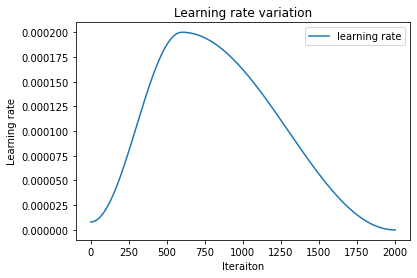

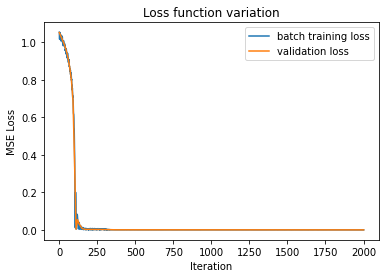

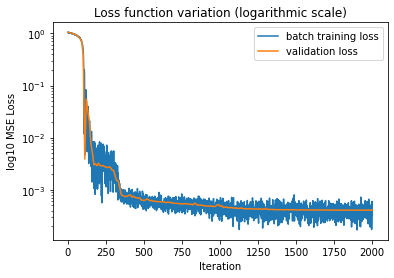

In [24]:
iter_count_train = np.linspace(1, 2001, 2001) # training loss and lr are recorded every iteration
iter_count_val = np.linspace(1, 2001, 201) # validation loss is recorded once per 10 iterations

plt.figure()
plt.title("Learning rate variation")
plt.plot(iter_count_train, lrs, label="learning rate") # plot learning rate variation
plt.xlabel("Iteraiton")
plt.ylabel("Learning rate")
plt.legend()
plt.show()

plt.figure()
plt.title("Loss function variation")
plt.plot(iter_count_train, train_losses, label="batch training loss") # loss of the current batch of training set

plt.plot(iter_count_val, val_losses, label="validation loss") # loss on validation set
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.show()

plt.figure()
plt.title("Loss function variation (logarithmic scale)")
plt.plot(iter_count_train, train_losses, label="batch training loss") # loss of the current batch of training set
plt.plot(iter_count_val, val_losses, label="validation loss") # loss on validation set
plt.legend()
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("log10 MSE Loss")
plt.show()
